<a href="https://colab.research.google.com/github/JackF-O/Cascaded-CNN-and-Object-Detection/blob/main/Cascaded%20CNN/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from pathlib import Path
from tensorflow import keras

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8515021298576701279
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17657990060861468140
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


# Import Data

In [ ]:
!unzip '/content/drive/MyDrive/plant_images_split.zip'

Streaming output truncated to the last 5000 lines.
  inflating: plant_images_split/images/Test/Scab/Test_505.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_505.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_707.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_707.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_72.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_72.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_99.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_99.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_101.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_101.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_458.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Scab/._Test_458.jpg  
  inflating: plant_images_split/images/Test/Scab/Test_302.jpg  
  inflating: __MACOSX/plant_images_split/images/Test/Sc

In [ ]:
train_dir = '/content/plant_images_split/images/Train'
train_files=Path(train_dir).glob('*.jpg')

In [ ]:
val_dir = '/content/plant_images_split/images/Validate'
val_files=Path(val_dir).glob('*.jpg')

NameError: ignored

In [ ]:
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
# train_builder = tfds.ImageFolder('/content/plant_images_split/images/')
# print(train_builder.info)
# ds = train_builder.as_dataset(split=None)
# # tfds.show_examples(ds, train_builder.info)

In [ ]:
# print(ds['Train'])

In [ ]:
# train_ds = ds['Train']
# val_ds = ds['Validate']

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size) #label_mode='categorical'

Found 2337 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 584 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Healthy', 'Multiple', 'Rust', 'Scab']


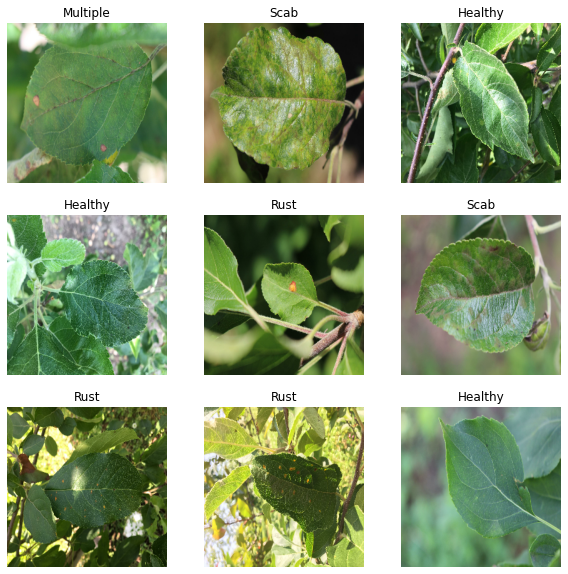

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.savefig('plants.pdf')

In [ ]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: ignored

# Define Model

In [ ]:
def inception1(x, filters):
    path1 = keras.layers.Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    path2 = keras.layers.Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = keras.layers.Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    path3 = keras.layers.Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = keras.layers.Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    path4 = keras.layers.MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = keras.layers.Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return keras.layers.Concatenate(axis=-1)([path1,path2,path3,path4])

In [ ]:

input = keras.layers.Input(shape=(512,512,3))

layer = keras.layers.experimental.preprocessing.Rescaling(1./256)(input)

layer = keras.layers.Conv2D(filters=96, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same')(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(4,4), padding='same')(layer)

layer = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = inception1(layer, [64,  (96,128), (16,32), 32])
layer = inception1(layer, [128, (128,192), (32,96), 64])

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(3,3), padding='same')(layer)
layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(layer)

layer = keras.layers.Dense(4)(layer)
layer = keras.layers.Dropout(0.5)(layer)

layer  = keras.layers.Flatten()(layer)
output = keras.layers.Softmax()(layer)




In [ ]:
model = keras.models.Model(inputs=input, outputs=output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_6 (Rescaling)         (None, 512, 512, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 128, 128, 96) 23424       rescaling_6[0][0]                
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 96) 384         conv2d_108[0][0]                 
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import SGD
opt = SGD(lr=0.004)
model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=300
)

Epoch 1/300
74/74 [==============================] - 42s 504ms/step - loss: 1.3548 - accuracy: 0.3423 - val_loss: 1.3849 - val_accuracy: 0.1866
Epoch 2/300
74/74 [==============================] - 6s 75ms/step - loss: 1.3845 - accuracy: 0.3119 - val_loss: 1.4005 - val_accuracy: 0.1866
Epoch 3/300
74/74 [==============================] - 6s 75ms/step - loss: 1.3717 - accuracy: 0.3067 - val_loss: 1.3993 - val_accuracy: 0.2825
Epoch 4/300
74/74 [==============================] - 6s 74ms/step - loss: 1.3488 - accuracy: 0.3275 - val_loss: 1.3936 - val_accuracy: 0.3065
Epoch 5/300
74/74 [==============================] - 5s 74ms/step - loss: 1.3278 - accuracy: 0.3499 - val_loss: 1.4011 - val_accuracy: 0.3116
Epoch 6/300
74/74 [==============================] - 5s 74ms/step - loss: 1.3257 - accuracy: 0.3525 - val_loss: 1.3908 - val_accuracy: 0.3065
Epoch 7/300
74/74 [==============================] - 5s 74ms/step - loss: 1.3157 - accuracy: 0.3709 - val_loss: 1.3920 - val_accuracy: 0.3253
Epoc

# Test

In [ ]:
test_dir = '/content/plant_images_split/images/Test'
test_files=Path(test_dir).glob('*.jpg')

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 721 files belonging to 4 classes.


In [ ]:
test_labels =  np.array([])
predict = np.array([])
for image, label in test_ds:
  predict = np.concatenate([predict, np.argmax(model.predict(image), axis = -1)])
  test_labels = np.concatenate([test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, predict)

In [ ]:
print(cm)

[[ 85   6  12  32]
 [  4   3  21  14]
 [ 10   2 256  12]
 [ 33   5  24 202]]


In [ ]:
class_names = test_ds.class_names
print(class_names)

['Healthy', 'Multiple', 'Rust', 'Scab']


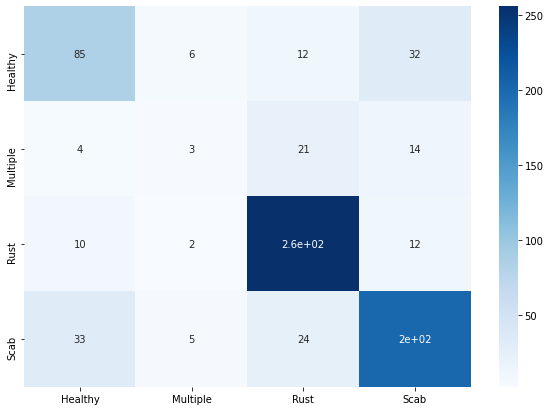

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues')

# Multi


In [ ]:
!unzip '/content/drive/MyDrive/plant_images_split_fake.zip'

Streaming output truncated to the last 5000 lines.
  inflating: plant_images_split_fake/images/Test/Rust/Test_430.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_430.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/Test_424.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_424.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/Test_169.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_169.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/Test_155.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_155.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/Test_633.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_633.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/Test_182.jpg  
  inflating: __MACOSX/plant_images_split_fake/images/Test/Rust/._Test_182.jpg  
  inflating: plant_images_split_fake/images/Test/Rust/T

In [ ]:
multi_train_dir = '/content/plant_images_split_fake/images/Train'
multi_train_files=Path(multi_train_dir).glob('*.jpg')

In [ ]:
multi_val_dir = '/content/plant_images_split_fake/images/Validate'
multi_val_files=Path(multi_val_dir).glob('*.jpg')

In [ ]:
multi_batch_size = 32
multi_img_height = 256
multi_img_width = 256

In [ ]:
multi_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  multi_train_dir,
  image_size=(multi_img_height, multi_img_width),
  batch_size=multi_batch_size,
  label_mode='categorical')

Found 2337 files belonging to 4 classes.


In [ ]:
multi_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  multi_val_dir,
  image_size=(multi_img_height, multi_img_width),
  batch_size=multi_batch_size,
  label_mode='categorical')

Found 584 files belonging to 4 classes.


In [ ]:
multi_class_names = multi_train_ds.class_names
print(multi_class_names)

['Healthy', 'Multiple', 'Rust', 'Scab']


In [ ]:
for image_batch, labels_batch in multi_train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32, 4)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

multi_train_ds = multi_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
multi_val_ds = multi_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
multi_input = keras.layers.Input(shape=(256,256,3))

layer = keras.layers.experimental.preprocessing.Rescaling(1./256)(multi_input)

layer = keras.layers.Conv2D(filters=96, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same')(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = inception1(layer, [64,  (96,128), (16,32), 32])
layer = inception1(layer, [128, (128,192), (32,96), 64])

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(4,4), padding='same')(layer)

layer = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(layer)

layer = keras.layers.Dense(4)(layer)
layer = keras.layers.Dropout(0.5)(layer)

layer  = keras.layers.Flatten()(layer)
multi_output = keras.layers.Softmax()(layer)

In [ ]:
multi_model = keras.models.Model(inputs=multi_input, outputs=multi_output)
multi_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 64, 64, 96)   23424       rescaling_1[0][0]                
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 64, 64, 96)   384         conv2d_18[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import SGD
opt = SGD(lr=0.004)
multi_model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
multi_history = multi_model.fit(
    multi_train_ds,
    validation_data=multi_val_ds,
    epochs=300
)

Epoch 1/300
74/74 [==============================] - 34s 409ms/step - loss: 1.3707 - accuracy: 0.2987 - val_loss: 1.3822 - val_accuracy: 0.3065
Epoch 2/300
74/74 [==============================] - 3s 38ms/step - loss: 1.3557 - accuracy: 0.3115 - val_loss: 1.3770 - val_accuracy: 0.4503
Epoch 3/300
74/74 [==============================] - 3s 38ms/step - loss: 1.3366 - accuracy: 0.3380 - val_loss: 1.3754 - val_accuracy: 0.3065
Epoch 4/300
74/74 [==============================] - 3s 39ms/step - loss: 1.3154 - accuracy: 0.3430 - val_loss: 1.3884 - val_accuracy: 0.3048
Epoch 5/300
74/74 [==============================] - 3s 38ms/step - loss: 1.3180 - accuracy: 0.3478 - val_loss: 1.4240 - val_accuracy: 0.0565
Epoch 6/300
74/74 [==============================] - 3s 38ms/step - loss: 1.3478 - accuracy: 0.3326 - val_loss: 1.3399 - val_accuracy: 0.3562
Epoch 7/300
74/74 [==============================] - 3s 38ms/step - loss: 1.2547 - accuracy: 0.4272 - val_loss: 1.3518 - val_accuracy: 0.3562
Epoc

# Multi Test

In [ ]:
multi_test_dir = '/content/plant_images_split_fake/images/Test'
multi_test_files=Path(test_dir).glob('*.jpg')

In [ ]:
multi_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  multi_test_dir,
  image_size=(multi_img_height, multi_img_width),
  batch_size=multi_batch_size)

Found 721 files belonging to 4 classes.


In [ ]:
multi_test_labels =  np.array([])
multi_predict = np.array([])
for image, label in multi_test_ds:
  multi_predict = np.concatenate([multi_predict, np.argmax(multi_model.predict(image), axis = -1)])
  multi_test_labels = np.concatenate([multi_test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
multi_cm = confusion_matrix(multi_test_labels, multi_predict)

In [ ]:
print(multi_cm)

[[ 84   8   0  43]
 [  1   8  21  12]
 [  7  23 237  13]
 [ 33  24   8 199]]


In [ ]:
multi_class_names = multi_test_ds.class_names
print(multi_class_names)

['Healthy', 'Multiple', 'Rust', 'Scab']


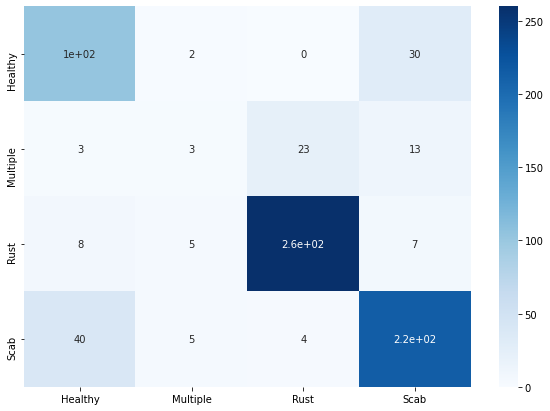

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

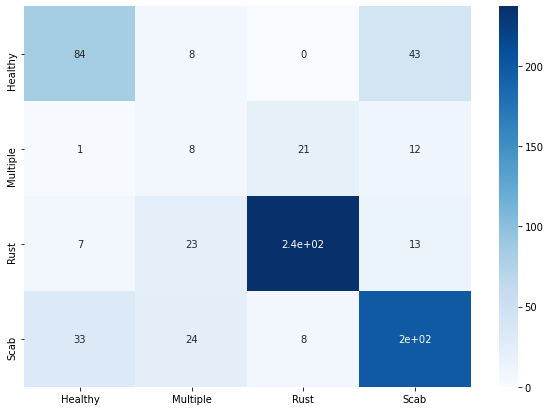

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

multi_df_cm = pd.DataFrame(multi_cm, index = multi_class_names,
                  columns = multi_class_names)
plt.figure(figsize = (10,7))
sn.heatmap(multi_df_cm, annot=True, cmap="Blues")

In [ ]:
cm_new = []
for i in cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  cm_new.append(row)

In [ ]:
multi_cm_new = []
for i in multi_cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  multi_cm_new.append(row)

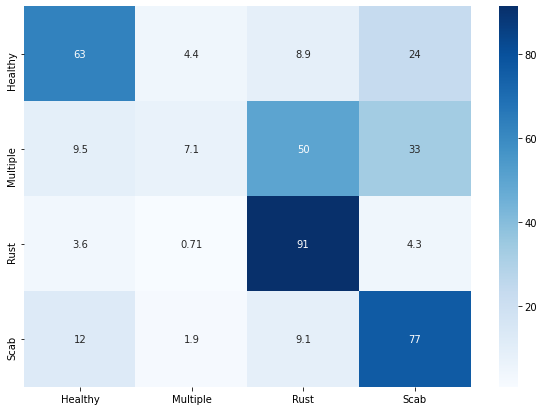

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_new = pd.DataFrame(cm_new, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_new, annot=True, cmap="Blues")
plt.savefig('/content/model.pdf')

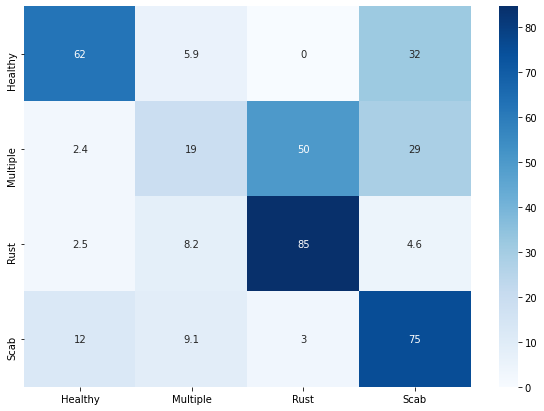

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

multi_df_cm_new = pd.DataFrame(multi_cm_new, index = multi_class_names,
                  columns = multi_class_names)
plt.figure(figsize = (10,7))
sn.heatmap(multi_df_cm_new, annot=True, cmap="Blues")
plt.savefig('/content/multi.pdf')

In [ ]:
ensemble_test_labels =  np.array([])
ensemble_predict = np.array([])
for image, label in multi_test_ds:
  mu = multi_model.predict(image)
  mo =  model.predict(image)
  preds = []
  for i in range(len(mo)):
    if np.argmax(mo[i], axis = -1) == 0:
      pred = [(2*x+3*y)/2 for x, y in zip(mu[i], mo[i])]
    elif np.argmax(mu[i], axis = -1) == 1:
      pred = [(4*x+1*y)/2 for x, y in zip(mu[i], mo[i])]
    else:
      pred = [(3*x+2*y)/2 for x, y in zip(mu[i], mo[i])]
    preds.append(pred)
  ensemble_predict = np.concatenate([ensemble_predict, np.argmax(preds, axis = -1)])
  ensemble_test_labels = np.concatenate([ensemble_test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
ensemble_cm = confusion_matrix(ensemble_test_labels, ensemble_predict)
print(ensemble_cm)

[[109   0   0  26]
 [  3   7  22  10]
 [  8  18 241  13]
 [ 46  15   6 197]]


In [ ]:
ensemble_cm_new = []
for i in ensemble_cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  ensemble_cm_new.append(row)

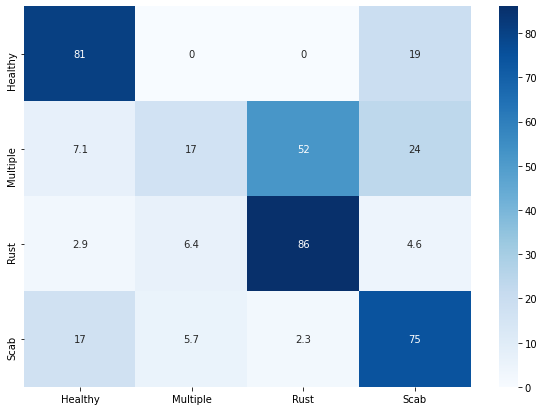

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

ensemble_df_cm_new = pd.DataFrame(ensemble_cm_new, index = multi_class_names,
                  columns = multi_class_names)
plt.figure(figsize = (10,7))
sn.heatmap(ensemble_df_cm_new, annot=True, cmap="Blues")

# SMOTE

In [ ]:
X = np.concatenate([x for x, y in train_ds], axis=0)
Y = np.concatenate([y for x, y in train_ds], axis=0)


In [ ]:
ys = []
for i in Y:
  y_int = np.argmax(i, axis = -1)
  ys.append(y_int)

In [ ]:
from collections import Counter
counter = Counter(ys)
sum_counter = len(ys)
fracts = [counter[0]/sum_counter, counter[1]/sum_counter, counter[2]/sum_counter, counter[3]/sum_counter]
print(counter[0], counter[1], counter[2], counter[3])
print(fracts)

626 131 818 762
[0.267864783910997, 0.05605477107402653, 0.3500213949507916, 0.32605905006418484]


In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(sampling_strategy={0:750,1:600,2:850,3:800}, random_state = 1) 

resample_x_train, resample_y_train = sm.fit_resample(X.reshape((-1, 256 * 256 * 3)), Y)
resample_x_train = resample_x_train.reshape((-1, 256, 256, 3))
resample_x_train.shape, resample_y_train.sum(axis=0)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (850) in class 2 will be larger than the number of samples in the majority class (class #2 -> 818)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarn

((3000, 256, 256, 3), array([750, 600, 850, 800]))

In [ ]:
ys_resample = []
for i in resample_y_train:
  y_int = np.argmax(i, axis = -1)
  ys_resample.append(y_int)

In [ ]:
from collections import Counter
counter = Counter(ys_resample)
sum_counter = len(ys_resample)
fracts = [counter[0]/sum_counter, counter[1]/sum_counter, counter[2]/sum_counter, counter[3]/sum_counter]
print(fracts)

[0.25, 0.2, 0.2833333333333333, 0.26666666666666666]


In [ ]:
print(train_ds)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 4)), types: (tf.float32, tf.float32)>


In [ ]:
resample_input = keras.layers.Input(shape=(256,256,3))

layer = keras.layers.experimental.preprocessing.Rescaling(1./256)(resample_input)

layer = keras.layers.Conv2D(filters=96, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same')(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = inception1(layer, [64,  (96,128), (16,32), 32])
layer = inception1(layer, [128, (128,192), (32,96), 64])

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(4,4), padding='same')(layer)

layer = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(layer)

layer = keras.layers.Dense(4)(layer)
layer = keras.layers.Dropout(0.5)(layer)

layer  = keras.layers.Flatten()(layer)
resample_output = keras.layers.Softmax()(layer)

In [ ]:
resample_model = keras.models.Model(inputs=resample_input, outputs=resample_output)
resample_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 96)   23424       rescaling_2[0][0]                
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 64, 64, 96)   384         conv2d_36[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import SGD
opt = SGD(lr=0.004)
resample_model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
resample_history = resample_model.fit(
    resample_x_train,
    resample_y_train,
    validation_data=val_ds,
    batch_size=32,
    epochs=300
)

Epoch 1/300
94/94 [==============================] - 6s 50ms/step - loss: 1.3903 - accuracy: 0.2735 - val_loss: 1.3804 - val_accuracy: 0.4503
Epoch 2/300
94/94 [==============================] - 4s 41ms/step - loss: 1.3361 - accuracy: 0.3553 - val_loss: 1.3800 - val_accuracy: 0.3596
Epoch 3/300
94/94 [==============================] - 4s 41ms/step - loss: 1.3188 - accuracy: 0.3864 - val_loss: 1.4063 - val_accuracy: 0.0668
Epoch 4/300
94/94 [==============================] - 4s 40ms/step - loss: 1.2994 - accuracy: 0.3859 - val_loss: 1.4260 - val_accuracy: 0.0976
Epoch 5/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2696 - accuracy: 0.4339 - val_loss: 1.3795 - val_accuracy: 0.2723
Epoch 6/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2655 - accuracy: 0.4242 - val_loss: 1.3175 - val_accuracy: 0.3955
Epoch 7/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2504 - accuracy: 0.4543 - val_loss: 1.1819 - val_accuracy: 0.6062
Epoch 

#Resample Test

In [ ]:
resample_test_labels =  np.array([])
resample_predict = np.array([])
for image, label in test_ds:
  resample_predict = np.concatenate([resample_predict, np.argmax(resample_model.predict(image), axis = -1)])
  resample_test_labels = np.concatenate([resample_test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
resample_cm = confusion_matrix(resample_test_labels, resample_predict)

In [ ]:
resample_cm_new = []
for i in resample_cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  resample_cm_new.append(row)

In [ ]:
print(resample_cm_new)

[[78.51851851851852, 0.0, 1.4814814814814816, 20.0], [9.523809523809524, 7.142857142857142, 52.38095238095239, 30.952380952380953], [3.571428571428571, 1.0714285714285714, 91.78571428571428, 3.571428571428571], [14.772727272727273, 1.5151515151515151, 1.893939393939394, 81.81818181818183]]


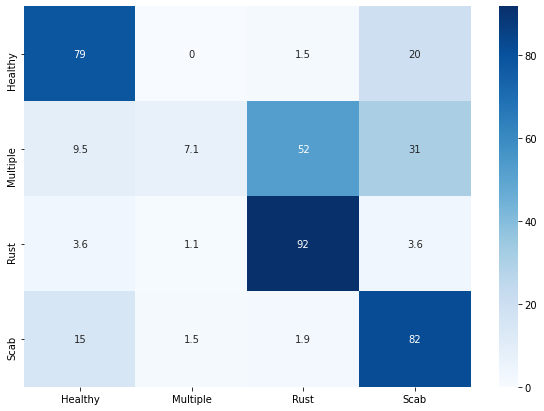

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

resample_df_cm_new = pd.DataFrame(resample_cm_new, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(resample_df_cm_new, annot=True, cmap="Blues")
plt.savefig('/content/resample.pdf')

# Resample Multi

In [ ]:
multi_X = np.concatenate([x for x, y in multi_train_ds], axis=0)
multi_Y = np.concatenate([y for x, y in multi_train_ds], axis=0)

In [ ]:
multi_ys = []
for i in multi_Y:
  y_int = np.argmax(i, axis = -1)
  multi_ys.append(y_int)

In [ ]:
from collections import Counter
counter = Counter(multi_ys)
sum_counter = len(multi_ys)
fracts = [counter[0]/sum_counter, counter[1]/sum_counter, counter[2]/sum_counter, counter[3]/sum_counter]
print(counter[0], counter[1], counter[2], counter[3])
print(fracts)

376 381 818 762
[0.1608900299529311, 0.16302952503209242, 0.3500213949507916, 0.32605905006418484]


In [ ]:
from imblearn.over_sampling import SMOTE 

multi_sm = SMOTE(sampling_strategy={0:750,1:600,2:850,3:800}, random_state = 1) 

resample_multi_x_train, resample_multi_y_train = multi_sm.fit_resample(multi_X.reshape((-1, 256 * 256 * 3)), multi_Y)
resample_multi_x_train = resample_multi_x_train.reshape((-1, 256, 256, 3))
resample_multi_x_train.shape, resample_multi_y_train.sum(axis=0)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (850) in class 2 will be larger than the number of samples in the majority class (class #2 -> 818)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarn

((3000, 256, 256, 3), array([750, 600, 850, 800]))

In [ ]:
multi_resample_input = keras.layers.Input(shape=(256,256,3))

layer = keras.layers.experimental.preprocessing.Rescaling(1./256)(multi_resample_input)

layer = keras.layers.Conv2D(filters=96, kernel_size=(9,9), strides=(4,4), activation='relu', padding='same')(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same")(layer)
layer = keras.layers.BatchNormalization()(layer)

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)
layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(layer)

layer = inception1(layer, [64,  (96,128), (16,32), 32])
layer = inception1(layer, [128, (128,192), (32,96), 64])

layer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(4,4), padding='same')(layer)

layer = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(layer)

layer = keras.layers.Dense(4)(layer)
layer = keras.layers.Dropout(0.5)(layer)

layer  = keras.layers.Flatten()(layer)
multi_resample_output = keras.layers.Softmax()(layer)

In [ ]:
multi_resample_model = keras.models.Model(inputs=multi_resample_input, outputs=multi_resample_output)
multi_resample_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 256, 256, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 64, 64, 96)   23424       rescaling_4[0][0]                
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 64, 64, 96)   384         conv2d_72[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.optimizers import SGD
opt = SGD(lr=0.004)
multi_resample_model.compile(
  optimizer=opt,
  loss=tf.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
multi_resample_history = multi_resample_model.fit(
    resample_multi_x_train,
    resample_multi_y_train,
    validation_data=val_ds,
    batch_size=32,
    epochs=300
)

Epoch 1/300
94/94 [==============================] - 6s 49ms/step - loss: 1.3984 - accuracy: 0.2668 - val_loss: 1.3878 - val_accuracy: 0.1866
Epoch 2/300
94/94 [==============================] - 4s 41ms/step - loss: 1.3501 - accuracy: 0.3344 - val_loss: 1.3933 - val_accuracy: 0.0856
Epoch 3/300
94/94 [==============================] - 4s 41ms/step - loss: 1.3395 - accuracy: 0.3370 - val_loss: 1.3992 - val_accuracy: 0.1884
Epoch 4/300
94/94 [==============================] - 4s 41ms/step - loss: 1.3183 - accuracy: 0.3649 - val_loss: 1.4086 - val_accuracy: 0.1918
Epoch 5/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2958 - accuracy: 0.4050 - val_loss: 1.3847 - val_accuracy: 0.2825
Epoch 6/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2695 - accuracy: 0.4290 - val_loss: 1.2934 - val_accuracy: 0.4435
Epoch 7/300
94/94 [==============================] - 4s 41ms/step - loss: 1.2346 - accuracy: 0.4578 - val_loss: 1.1951 - val_accuracy: 0.5582
Epoch 

#Resample Multi Test

In [ ]:
multi_resample_test_labels =  np.array([])
multi_resample_predict = np.array([])
for image, label in test_ds:
  multi_resample_predict = np.concatenate([multi_resample_predict, np.argmax(multi_resample_model.predict(image), axis = -1)])
  multi_resample_test_labels = np.concatenate([multi_resample_test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
multi_resample_cm = confusion_matrix(multi_resample_test_labels, multi_resample_predict)

In [ ]:
multi_resample_cm_new = []
for i in multi_resample_cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  multi_resample_cm_new.append(row)

In [ ]:
print(multi_resample_cm_new)

[[68.88888888888889, 3.7037037037037033, 0.0, 27.40740740740741], [0.0, 30.952380952380953, 50.0, 19.047619047619047], [0.0, 2.857142857142857, 92.5, 4.642857142857143], [6.8181818181818175, 3.0303030303030303, 2.6515151515151514, 87.5]]


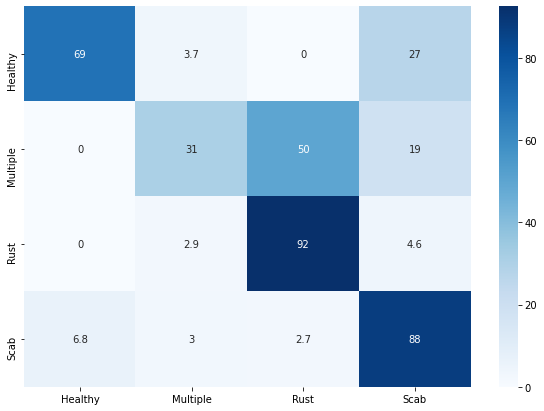

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

multi_resample_df_cm_new = pd.DataFrame(multi_resample_cm_new, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(multi_resample_df_cm_new, annot=True, cmap="Blues")
plt.savefig('/content/multi_resample.pdf')

In [ ]:
ensemble_test_labels =  np.array([])
ensemble_predict = np.array([])
for image, label in multi_test_ds:
  mu = multi_resample_model.predict(image)
  mo =  resample_model.predict(image)
  preds = []
  for i in range(len(mo)):
    if np.argmax(mu[i], axis = -1) == 1:
      pred = [(4*x+1*y)/2 for x, y in zip(mu[i], mo[i])]
    elif np.argmax(mo[i], axis = -1) == 0:
      pred = [(1*x+4*y)/2 for x, y in zip(mu[i], mo[i])]
    elif np.argmax(mu[i], axis = -1) == 4:
      pred = [(4*x+1*y)/2 for x, y in zip(mu[i], mo[i])]
    else:
      pred = [(3*x+2*y)/2 for x, y in zip(mu[i], mo[i])]
    preds.append(pred)
  ensemble_predict = np.concatenate([ensemble_predict, np.argmax(preds, axis = -1)])
  ensemble_test_labels = np.concatenate([ensemble_test_labels, label])

In [ ]:
from sklearn.metrics import confusion_matrix
ensemble_cm = confusion_matrix(ensemble_test_labels, ensemble_predict)

In [ ]:
ensemble_cm_new = []
for i in ensemble_cm:
  row_sum = sum(i)
  row = []
  for j in i:
    percent = 100*(j/row_sum)
    row.append(percent)
  ensemble_cm_new.append(row)

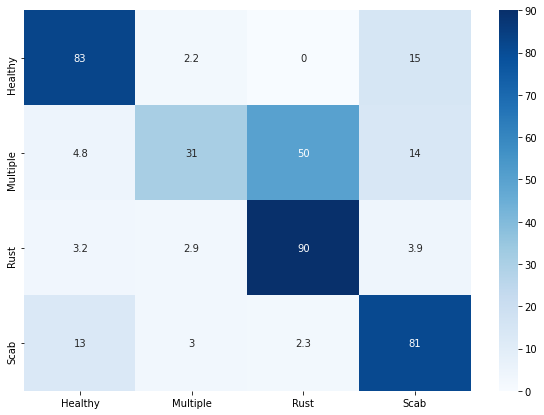

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

ensemble_df_cm_new = pd.DataFrame(ensemble_cm_new, index = multi_class_names,
                  columns = multi_class_names)
plt.figure(figsize = (10,7))
sn.heatmap(ensemble_df_cm_new, annot=True, cmap="Blues")
plt.savefig('/content/ensemble.pdf')

In [ ]:
print(resample_history)

In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('/content/model')
multi_model.save('/content/multi_model')
resample_model.save('/content/resample_model')
multi_resample_model.save('/content/multi_resample_model')

INFO:tensorflow:Assets written to: /content/model/assets
INFO:tensorflow:Assets written to: /content/multi_model/assets
INFO:tensorflow:Assets written to: /content/resample_model/assets
INFO:tensorflow:Assets written to: /content/multi_resample_model/assets


In [ ]:
!zip -r /content/model.zip /content/model
!zip -r /content/multi_model.zip /content/multi_model
!zip -r /content/resample_model.zip /content/resample_model
!zip -r /content/multi_resample_model.zip /content/multi_resample_model

In [ ]:
import pickle

In [ ]:
with open('/model_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

with open('/multi_model_history', 'wb') as file_pi:
        pickle.dump(multi_history.history, file_pi)

with open('/resample_model_history', 'wb') as file_pi:
        pickle.dump(resample_history.history, file_pi)

with open('/multi_resample_model_history', 'wb') as file_pi:
        pickle.dump(multi_resample_history.history, file_pi)

In [ ]:
for i in history.history:
  print(i)

loss
accuracy
val_loss
val_accuracy


# F1 Scores

In [ ]:
!unzip '/content/drive/MyDrive/model.zip'
!unzip '/content/drive/MyDrive/resample_model.zip'
!unzip '/content/drive/MyDrive/multi_model.zip'
!unzip '/content/drive/MyDrive/multi_resample_model.zip'

Archive:  /content/drive/MyDrive/model.zip
   creating: content/model/
   creating: content/model/variables/
  inflating: content/model/variables/variables.data-00000-of-00001  
  inflating: content/model/variables/variables.index  
  inflating: content/model/saved_model.pb  
   creating: content/model/assets/
Archive:  /content/drive/MyDrive/resample_model.zip
   creating: content/resample_model/
   creating: content/resample_model/variables/
  inflating: content/resample_model/variables/variables.data-00000-of-00001  
  inflating: content/resample_model/variables/variables.index  
  inflating: content/resample_model/saved_model.pb  
   creating: content/resample_model/assets/
Archive:  /content/drive/MyDrive/multi_model.zip
   creating: content/multi_model/
   creating: content/multi_model/variables/
  inflating: content/multi_model/variables/variables.data-00000-of-00001  
  inflating: content/multi_model/variables/variables.index  
  inflating: content/multi_model/saved_model.pb  


In [ ]:
new_model = tf.keras.models.load_model('/content/content/model')


In [ ]:
test_dir = '/content/plant_images_split/images/Test'
test_files=Path(test_dir).glob('*.jpg')

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(256, 256),
  batch_size=32)

Found 721 files belonging to 4 classes.


In [ ]:
X_test = []
Y_test = []
for i,j in test_ds:
  X_test.append(i)
  Y_test.append(j)

In [ ]:
X_test_2 = np.concatenate(X_test, axis=0)
Y_test_2 = np.concatenate(Y_test, axis=0)

In [ ]:
ys = []
for i in Y_test:
  y_int = i
  ys.append(y_int)

In [ ]:
from collections import Counter
counter = Counter(ys)
sum_counter = len(ys)
fracts = [counter[0]/sum_counter, counter[1]/sum_counter, counter[2]/sum_counter, counter[3]/sum_counter]
print(fracts)

TypeError: ignored

In [ ]:
from sklearn.metrics import classification_report

y_pred = new_model.predict(X_test_2)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test_2, y_pred_bool))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       135
           1       0.20      0.07      0.11        42
           2       0.91      0.93      0.92       280
           3       0.81      0.81      0.81       264

    accuracy                           0.81       721
   macro avg       0.65      0.64      0.64       721
weighted avg       0.79      0.81      0.79       721



In [ ]:
new_model_resample = tf.keras.models.load_model('/content/content/resample_model')

In [ ]:
y_pred = new_model_resample.predict(X_test_2, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test_2, y_pred_bool))

12/12 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.67      0.79      0.72       135
           1       0.30      0.07      0.12        42
           2       0.90      0.92      0.91       280
           3       0.81      0.82      0.82       264

    accuracy                           0.81       721
   macro avg       0.67      0.65      0.64       721
weighted avg       0.79      0.81      0.79       721



In [ ]:
new_model_multi = tf.keras.models.load_model('/content/content/multi_model')

In [ ]:
y_pred = new_model_multi.predict(X_test_2, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test_2, y_pred_bool))

12/12 [==============================] - 1s 30ms/step
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       135
           1       0.13      0.19      0.15        42
           2       0.89      0.85      0.87       280
           3       0.75      0.75      0.75       264

    accuracy                           0.73       721
   macro avg       0.61      0.60      0.60       721
weighted avg       0.75      0.73      0.74       721



In [ ]:
new_model_multi_resample = tf.keras.models.load_model('/content/content/multi_resample_model')

In [ ]:
y_pred = new_model_multi_resample.predict(X_test_2, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test_2, y_pred_bool))

12/12 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       135
           1       0.38      0.31      0.34        42
           2       0.90      0.93      0.91       280
           3       0.80      0.88      0.84       264

    accuracy                           0.83       721
   macro avg       0.73      0.70      0.71       721
weighted avg       0.82      0.83      0.82       721



In [ ]:
ensemble_test_labels =  np.array([])
ensemble_predict = np.array([])
# for i in range(len(Y_test_2)):
image = X_test_2
label = Y_test_2
mu = new_model_multi_resample.predict(image)
mo =  new_model.predict(image)
preds = []
for i in range(len(mo)):
  if np.argmax(mu[i], axis = -1) == 1:
    pred = [(4*x+1*y)/2 for x, y in zip(mu[i], mo[i])]
  elif np.argmax(mu[i], axis = -1) == 3:
    pred = [(3*x+1*y)/2 for x, y in zip(mu[i], mo[i])]
  elif np.argmax(mu[i], axis = -1) == 2:
    pred = [(3*x+2*y)/2 for x, y in zip(mu[i], mo[i])]
  elif np.argmax(mo[i], axis = -1) == 0:
    pred = [(1*x+3*y)/2 for x, y in zip(mu[i], mo[i])]
  else:
    pred = [(3*x+2*y)/2 for x, y in zip(mu[i], mo[i])]
  preds.append(pred)
ensemble_predict = np.concatenate([ensemble_predict, np.argmax(preds, axis = -1)])
ensemble_test_labels = np.concatenate([ensemble_test_labels, label])

In [ ]:
print(ensemble_predict)

In [ ]:
print(classification_report(Y_test_2, ensemble_predict))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       135
           1       0.41      0.31      0.35        42
           2       0.91      0.93      0.92       280
           3       0.80      0.88      0.84       264

    accuracy                           0.83       721
   macro avg       0.74      0.71      0.72       721
weighted avg       0.83      0.83      0.83       721



In [ ]:
import pickle
import matplotlib.pyplot as plt


# Plots

In [ ]:
with open('/content/drive/MyDrive/model_history', 'rb') as handle:
    model_history = pickle.load(handle)

with open('/content/drive/MyDrive/multi_resample_model_history', 'rb') as handle:
    model_mr_history = pickle.load(handle)

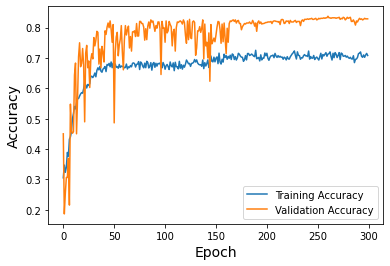

In [ ]:
plt.plot(model_history['accuracy'], label='Training Accuracy')
plt.plot(model_history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('accuracy.pdf')

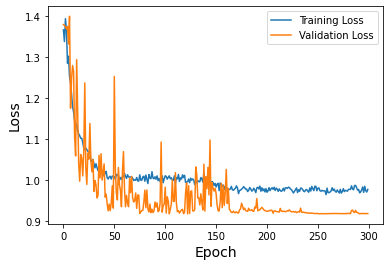

In [ ]:
plt.plot(model_history['loss'], label='Training Loss')
plt.plot(model_history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.savefig('loss.pdf')

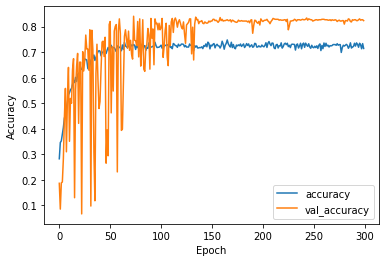

In [ ]:
plt.plot(model_mr_history['accuracy'], label='accuracy')
plt.plot(model_mr_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('accuracy_mr.pdf')

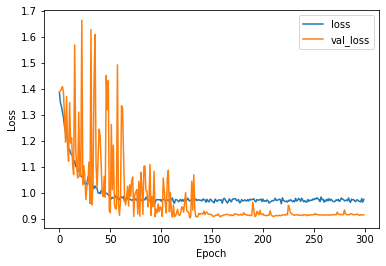

In [ ]:
plt.plot(model_mr_history['loss'], label='loss')
plt.plot(model_mr_history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.savefig('loss_mr.pdf')